In [171]:
# Random toy data set for classification visualization.
from sklearn.datasets import make_moons 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [172]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [173]:
#Adaboost from scratch

# step 1. sample from dataframe with weightages
# step 2. fit predict a weak learner from above sample
# step 3. get "amount of say" based on the accuracy of prediction
# step 4. update the weightages based on the ammount of say and the sign of prediction.
            #eg if the estimator has high accuracy:- 
                    #for sample that it predicts correctly, the weightages will decrease much more (logarithm)
                    #for sample that it predicts incorrectly, the weightages will increase much more (logarithm)
            #eg if the estimator has low accuracy:- 
                    #for sample that it predicts correctly, the weightages will decrease lesser (logarithm)
                    #for sample that it predicts incorrectly, the weightages will increase lesser (logarithm)
#step 5: make prediction based on all models corresponding with its ammount of say

In [174]:
#step1
def make_sample(X, y, weightages):
    
    #make indices
    indices = np.arange(X.shape[0])
    
    #return selected indices
    indices = np.random.choice(indices, size=X.shape[0], replace=True, p=weightages)

    return X[indices, :], y[indices]


### $$ \alpha_t = \frac{1}{2}ln \left(\frac{1-\epsilon_t}{\epsilon_t}\right) \text{where } \epsilon_t < 1$$

### $$ \epsilon_t = \frac{\text{misclassifications}_t}{\text{observations}_t} $$

In [184]:
#step 3
def get_alpha(y_true, y_pred):
    
    error = np.mean( y_pred != y_true)
    print(error)
    assert error < 1, "value of error must be smaller than 1"
    
    return 0.5 * np.log((1 - error )/ error)
    

### $$ D_{t+1}(i) = D_t(i) e^{-\alpha_t y_i h_t(x_i)} $$
### $$ D_{t+1}(i) = \frac{D_{t+1}(i)}{\sum_{i=1}^N D_{t+1}(i)}$$

In [196]:
#step 4
def update_weightages(X, y_trues, D, alpha, dtc, ):
    
    sign = np.array([1 if y_true == y_pred else -1 for y_true, y_pred in zip(y_trues, dtc.predict(X))])
    
    updated_D = D*np.exp(-alpha*sign)
    updated_D = updated_D / sum(updated_D)
    
    return updated_D
    

### $$ AdaBoost(X) = sign\left(\sum_{t=1}^T\alpha_t h_t(X)\right) $$

In [192]:
def adaboost(X, estimators, alphas):
    
    predicts = np.zeros(X.shape[0])
    for alpha, estimator in zip(alphas, estimators):
        
        prediction = np.array([1 if y_pred == 1 else -1 for y_pred in estimator.predict(X)])
        predicts = predicts + alpha*prediction
    
    result = np.sign(predicts)
    return np.array([1 if y == 1 else 0 for y in result])
        

In [199]:
moons = make_moons(n_samples=30, noise=0.75, random_state=42)
X, y = moons
X = StandardScaler().fit_transform(X)

# Create separate sample areas.
x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

In [200]:
def plot_adaboost(X, y, xx, yy, clf, D):
    from matplotlib.colors import ListedColormap

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result in a color plot.
    Z = Z.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(9,7))
    
    ss = [30 + 2500*w for w in D]

    cm_dark = ListedColormap(['#1F77B4', '#FF7F0E'])
    cm_light = ListedColormap(['#729ECE', '#FF9E4A'])
    # Plot the training points.
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark, s=ss)

    ax.contourf(xx, yy, Z, cmap=cm_light, alpha=.25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    plt.show()

ITERATION: 0
0.1
alpha=1.0986122886681098
Accuracy: 0.9
ITERATION: 1
0.3333333333333333
alpha=0.34657359027997275
Accuracy: 0.9


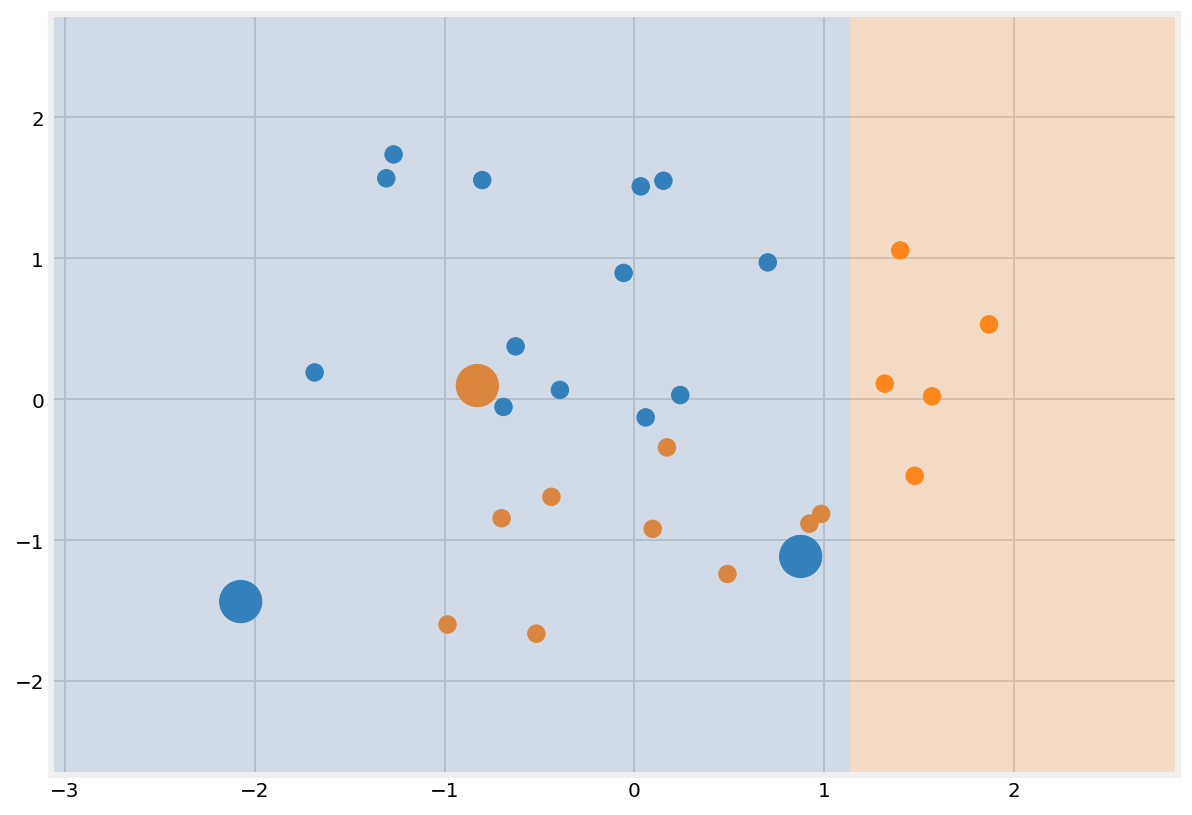

ITERATION: 2
0.23333333333333334
alpha=0.5947920334369182
Accuracy: 0.9


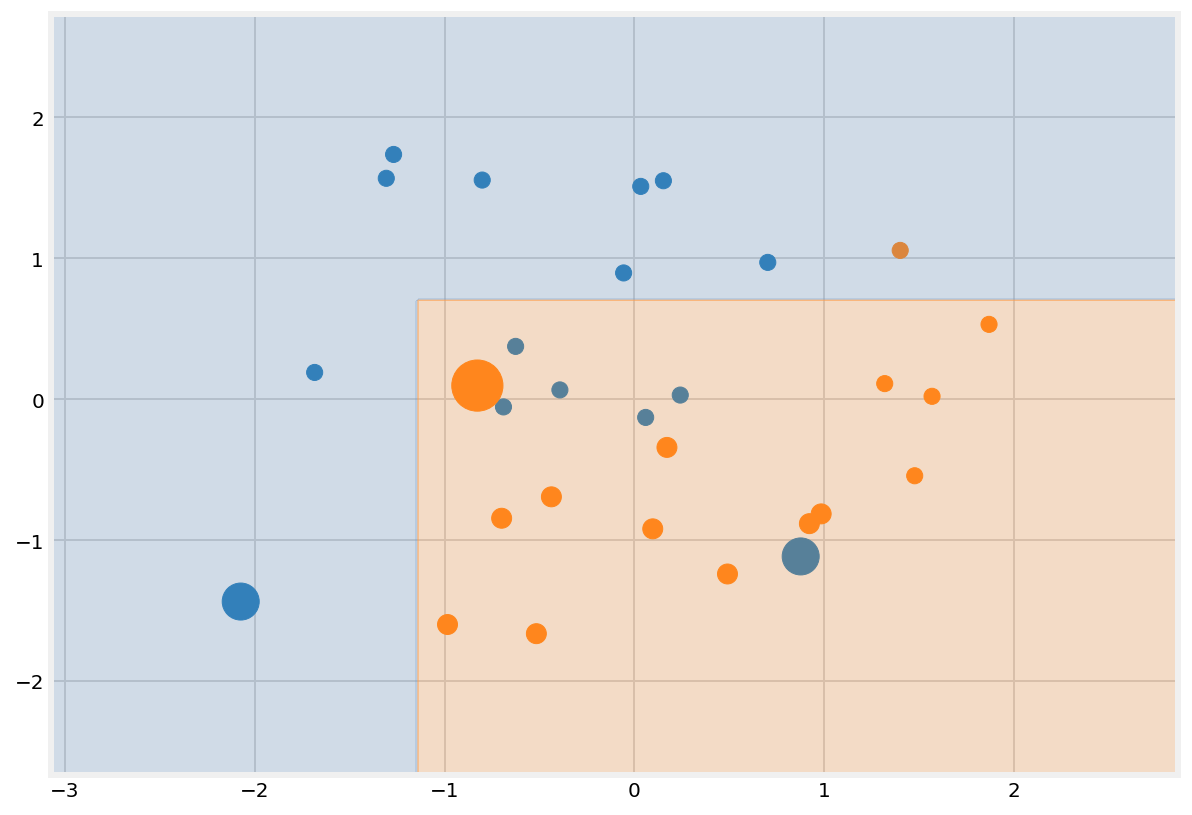

ITERATION: 3
0.6
alpha=-0.20273255405408214
Accuracy: 0.9


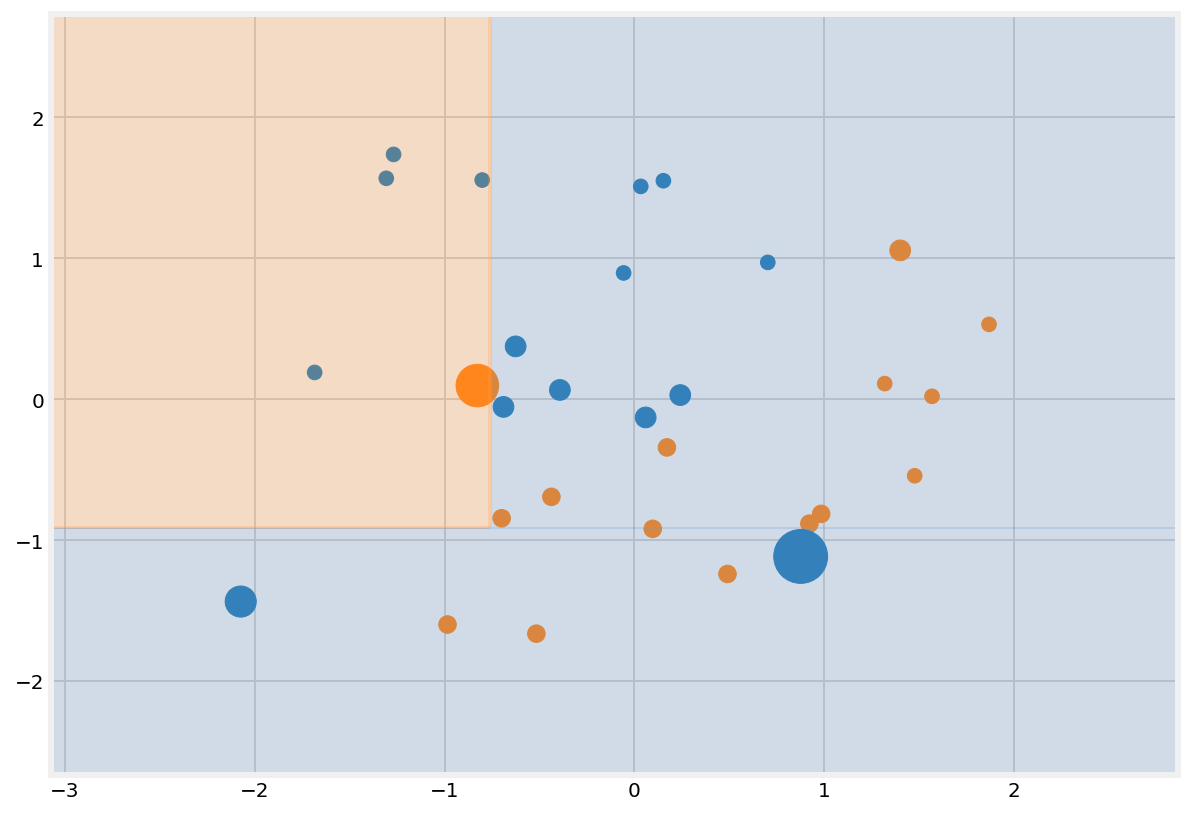

ITERATION: 4
0.26666666666666666
alpha=0.50580045583924
Accuracy: 0.9333333333333333


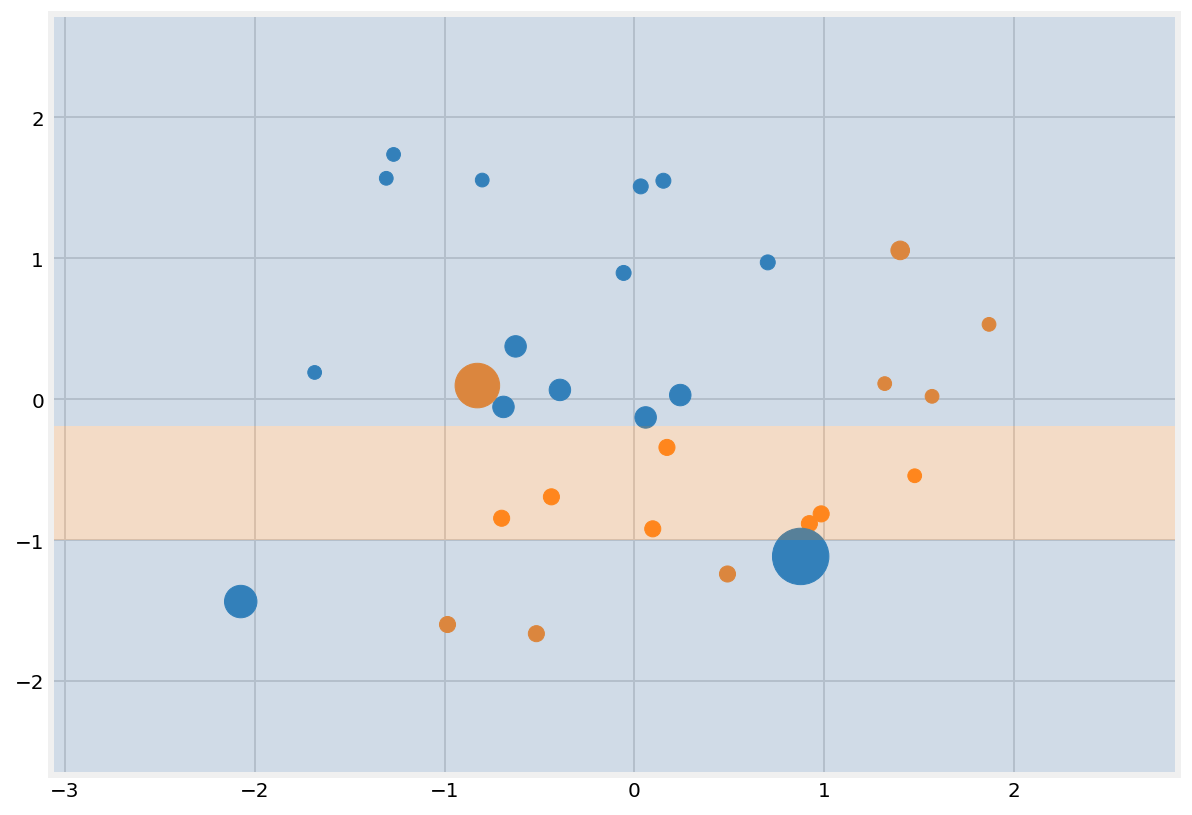

ITERATION: 5
0.6333333333333333
alpha=-0.27327185318403496
Accuracy: 0.9


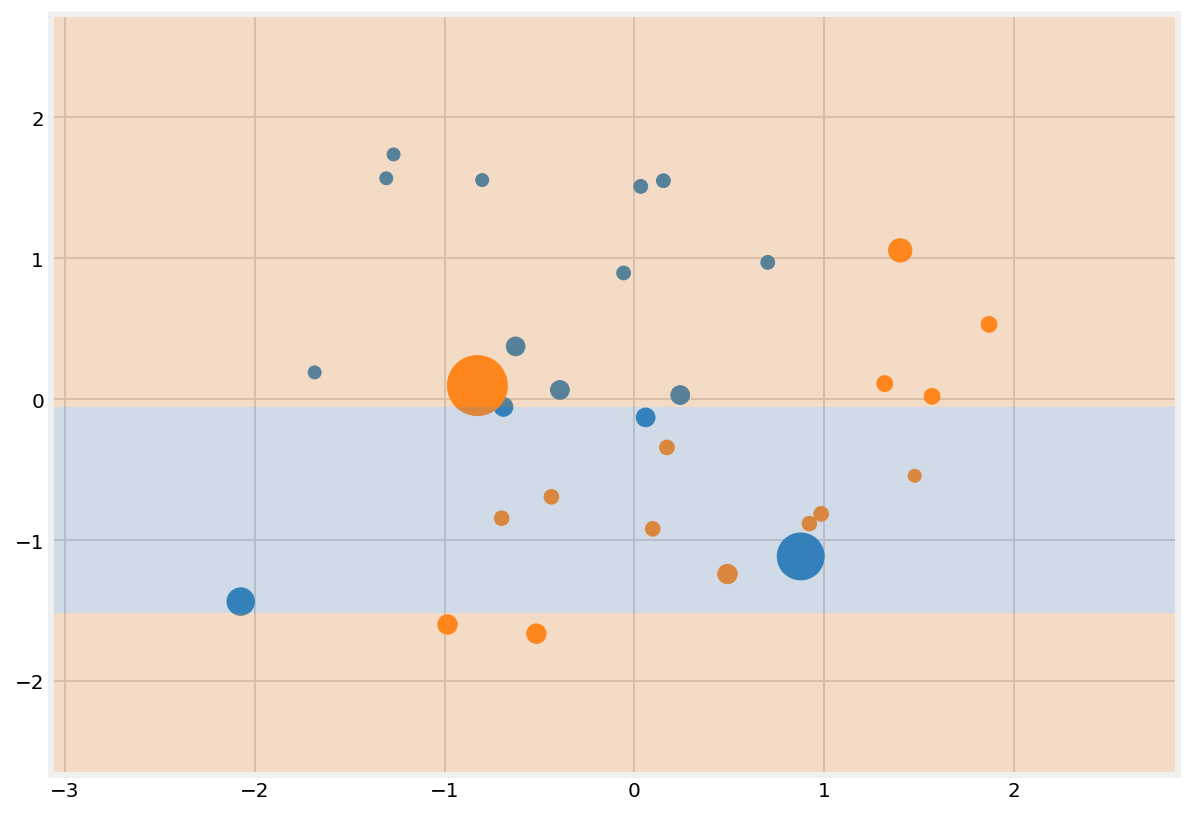

ITERATION: 6
0.4666666666666667
alpha=0.06676569631226129
Accuracy: 0.9


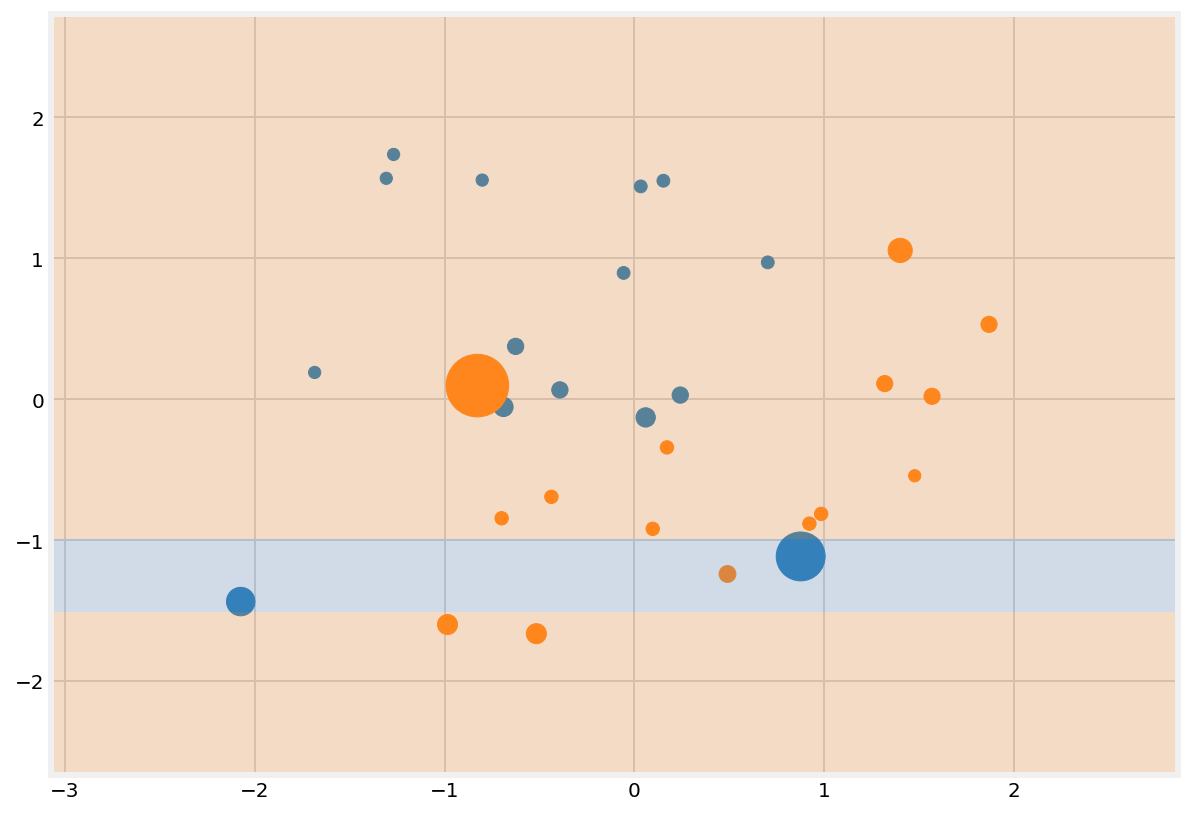

ITERATION: 7
0.3333333333333333
alpha=0.34657359027997275
Accuracy: 0.9


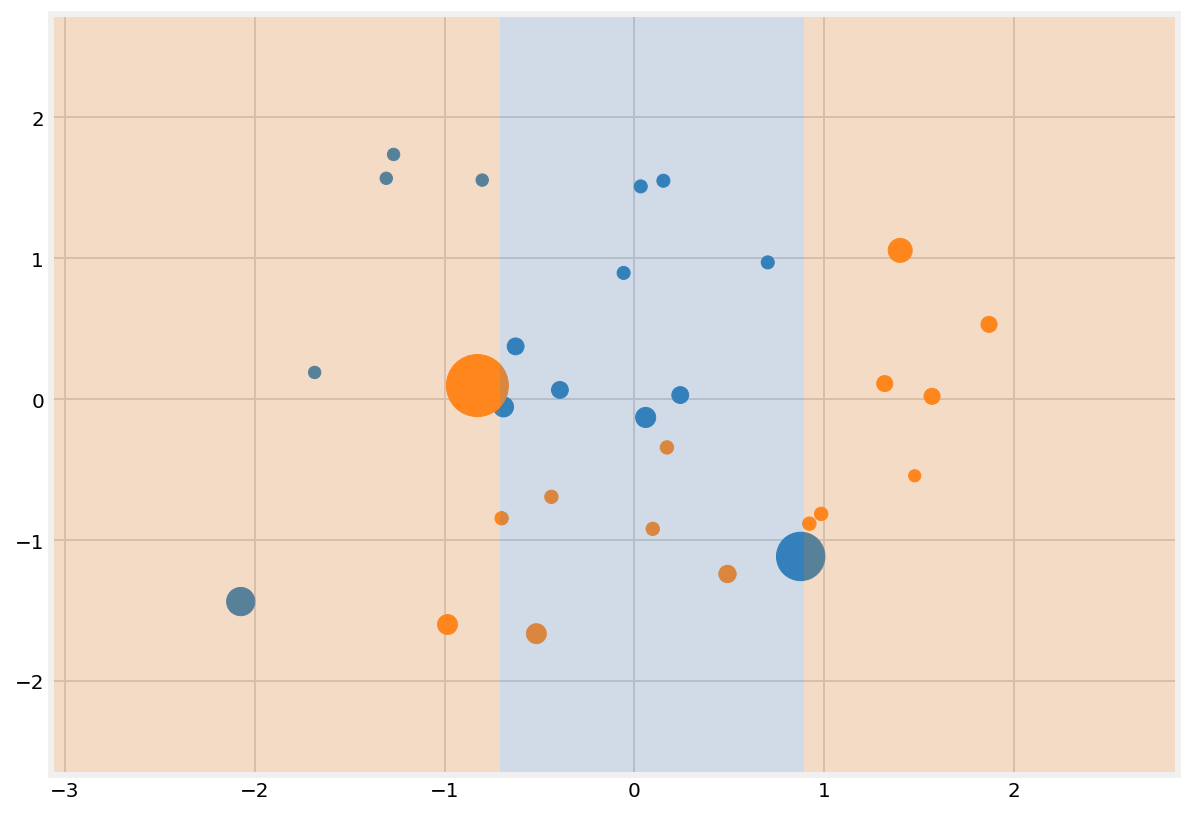

ITERATION: 8
0.6
alpha=-0.20273255405408214
Accuracy: 0.9


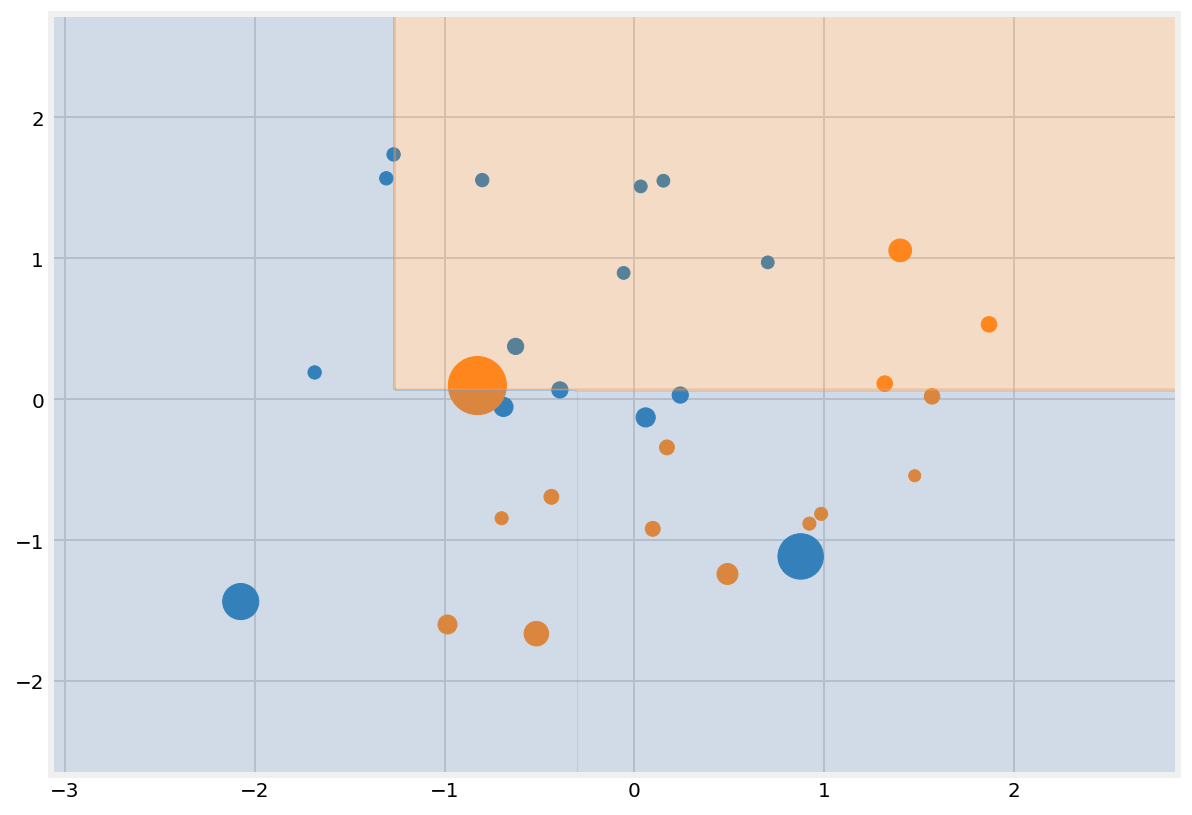

ITERATION: 9
0.5
alpha=0.0
Accuracy: 0.9


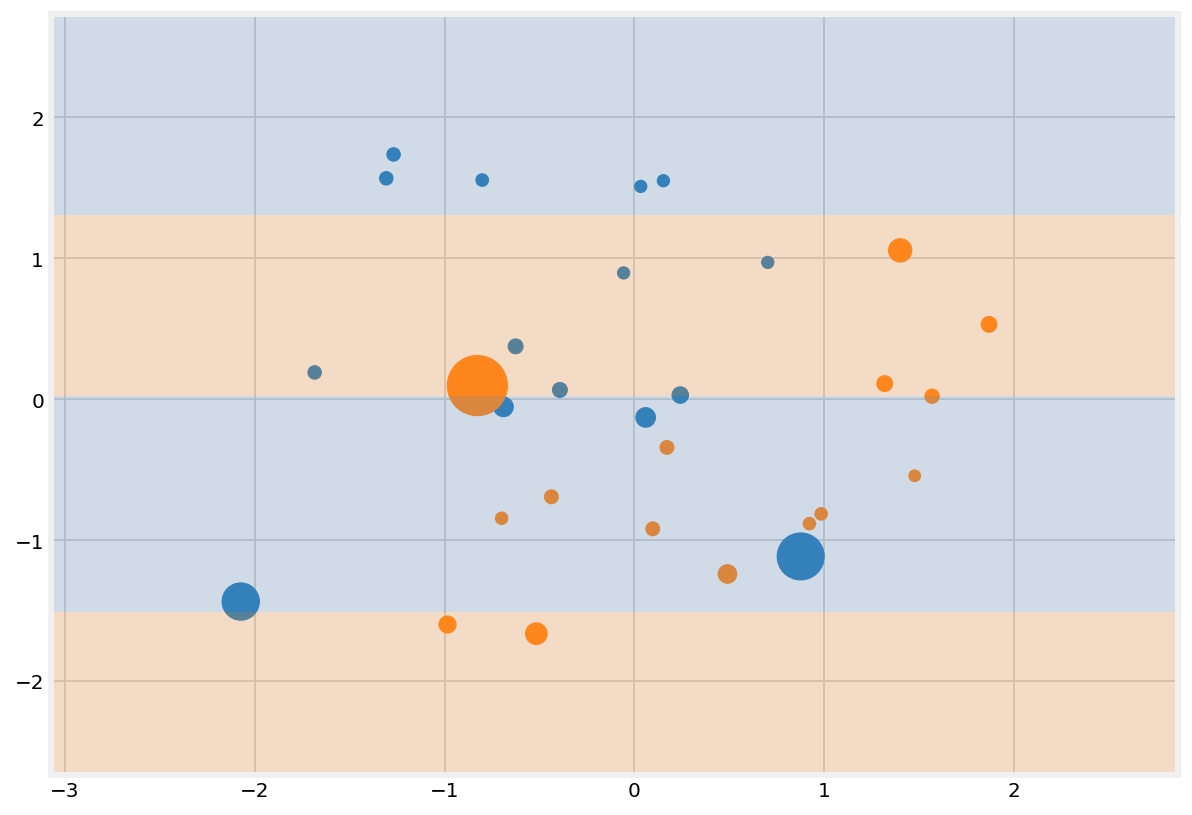

[1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0]


In [205]:
np.random.seed(2)
n_estimators = 10
estimators = []
D = np.ones(len(y))/len(y)
alphas = []
Ds = []

for i in range(n_estimators):
    print('ITERATION:', i)
    
    # step 1. sample from dataframe with weightages
    X_boot, y_boot = make_sample(X, y, D)
    
    # step 2. fit from above sample & predict a weak learner 
    dtc = DecisionTreeClassifier(max_depth=2)
    dtc.fit(X_boot, y_boot)

    yhat = dtc.predict(X)
    
    # step 3. get "amount of say" based on the accuracy of prediction
    alpha = get_alpha(y, yhat)
    
    print(f'{alpha=}')
    
    # step 4. update the weightages based on the ammount of say and the sign of prediction.
    D = update_weightages(X, y, D, alpha, dtc)
    
    estimators.append(dtc)
    alphas.append(alpha)
    Ds.append(D)

    #step 5: make prediction based on all models corresponding with its ammount of say
    predictions = adaboost(X, estimators, alphas)
    print('Accuracy:', np.mean(y == predictions))
    
    if i > 0:
        plot_adaboost(X, y, xx, yy, dtc, Ds[-2])
print(predictions)    